<a href="https://colab.research.google.com/github/horizoncrafts/dwchallenge/blob/master/challange03/day05/day05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install livelossplot

In [1]:
!nvidia-smi

Fri May 17 08:14:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from imgaug import augmenters as iaa
from imgaug import parameters as iap

import random

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda

from livelossplot import PlotLossesKeras

In [3]:
!pwd
X = np.load('x.npy')
Y = np.load('y.npy')

/content


In [4]:
print(X.shape, Y.shape)

(9720, 60, 80, 3) (9720,)


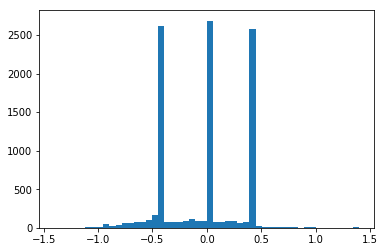

In [5]:
plt.hist(Y, 50);

In [6]:
next( filter( lambda x: x!=0, Y) )

-0.15

In [7]:
print(len(Y))

for i, elem in enumerate(Y):
    if elem != 0:
        break

print(i)

9720
15


-0.15


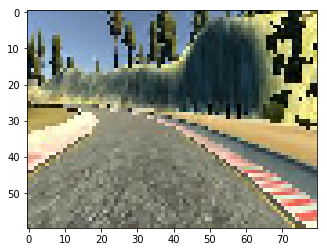

0.23


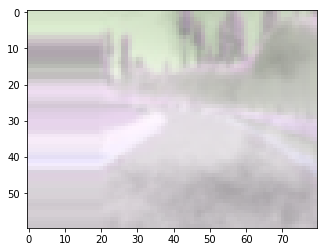

In [8]:
measurement_id = i

def augment(img, steering_angle):
    # Flip
    if random.random() > 0.5:
        img = img[:, ::-1, :]
        steering_angle = -steering_angle

    # Blur
    blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1.0))
    img = blurer.augment_image(img)
    
    # Shuffle
    sh = iaa.ChannelShuffle(p=0.5)
    img = sh.augment_image(img)
    
    # Snow
    fog = iaa.Fog()
    img = fog.augment_image(img)
    
    # Translate
    tx = random.randint(-20, 20)
    translator = iaa.Affine(translate_px={"x":tx}, mode='edge')
    img = translator.augment_image(img)
    steering_angle += tx * 0.02
    
    return img, steering_angle

plt.imshow(X[measurement_id])
print(Y[measurement_id])
plt.show();

img, angle = augment(X[measurement_id], Y[measurement_id])
plt.imshow(img)
print(angle)
plt.show();

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [10]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(7776, 60, 80, 3) (7776,)
(1944, 60, 80, 3) (1944,)


In [11]:
Xgen = []
ygen = []

for i in range(X_train.shape[0]):
    img, angle = augment(X[i], Y[i])
    Xgen.append(img)
    ygen.append(angle)
    
Xgen = np.array(Xgen)
ygen = np.array(ygen)

print(Xgen.shape, ygen.shape)

(7776, 60, 80, 3) (7776,)


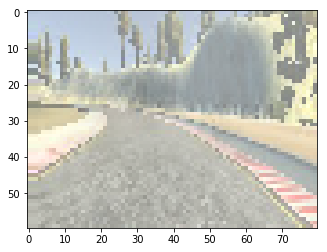

In [12]:
plt.imshow(Xgen[0])

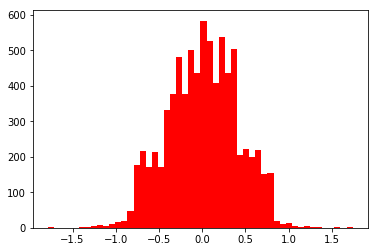

In [13]:
#plt.hist(Y_train, 50, facecolor='blue');
plt.hist(ygen, 50, facecolor='red');

In [26]:
def my_model( input_shape ):
  model = Sequential([
      Lambda( lambda x: (x-128)/255, input_shape=input_shape, name='normalize' ),
      Conv2D( 64, (3,3), activation='relu' ),
      #MaxPooling2D( pool_size=(2,2) ),
      Conv2D( 32, (3,3), activation='relu' ),
      MaxPooling2D( pool_size=(2,2) ),
      Conv2D( 16, (3,3), activation='relu' ),
      MaxPooling2D( pool_size=(2,2) ),
      Conv2D( 8,  (3,3), activation='relu' ),
      MaxPooling2D( pool_size=(2,2) ),
      Dropout( rate=0.5 ),
      Flatten(),
      Dense(512, activation='relu'),
      Dropout( rate=0.3 ),      
      Dense(512, activation='relu'),
      Dropout( rate=0.3 ),      
      Dense(16, activation='relu'),
      Dense(1)
  ])
  return model

mymodel = my_model(X[0].shape)
mymodel.summary()
mymodel.compile('adam','mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 16, 8)         1160      
__________

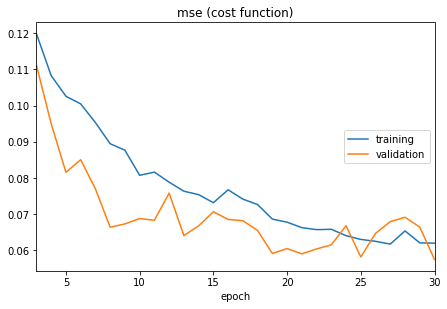

mse (cost function):
training   (min:    0.062, max:    0.161, cur:    0.062)
validation (min:    0.057, max:    0.125, cur:    0.057)


In [32]:
batch_size = 512
epochs = 30

mymodel.fit(Xgen, ygen, batch_size=batch_size, epochs=epochs,
         validation_data=(X_val, Y_val),
         callbacks=[PlotLossesKeras()]
         )



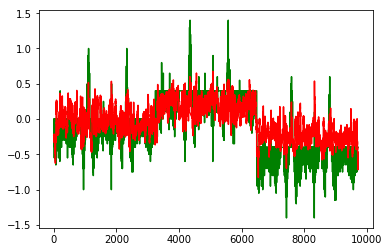

In [34]:
ypred = mymodel.predict(X)
plt.plot(Y, 'g', ypred, 'r')
plt.show();

In [0]:
mymodel.save('mymodel.h5')